In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')

import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import os
import gene as bgene
import shuffle
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

2024-03-13 09:09:20.745750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/motif_level/')
csv_dir = '../results/summary_csvs/enformer/motif_analysis/'



# XSTREME

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


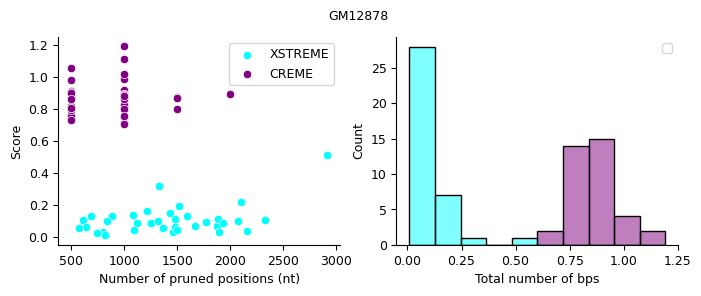

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


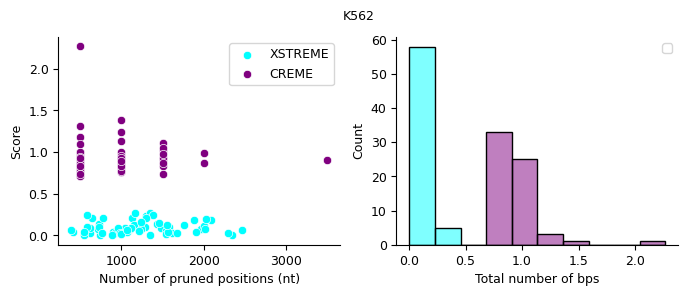

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


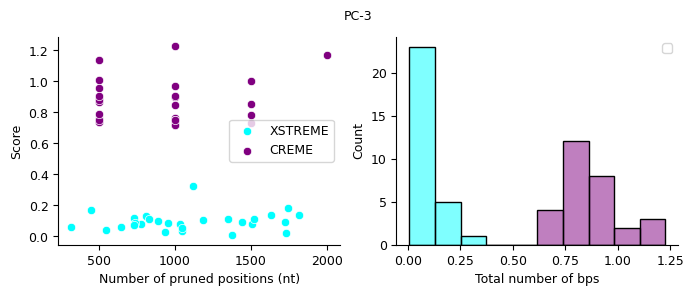

In [26]:
fontsize=9
dfs = pd.read_csv(f"{csv_dir}/XSTREME_vs_CREME.csv")
for cell_line, df in dfs.groupby('cell_line'):
    fig, axes = plt.subplots(1, 2, figsize=[8, 2.7])

    sns.scatterplot(data=df, x='XSTREME bps', y='XSTREME score', color='cyan', label='XSTREME', ax=axes[0])
    sns.scatterplot(data=df, x='CREME bps', y='CREME score', color='purple', label='CREME', ax=axes[0])
    axes[0].set_xlabel('Number of pruned positions (nt)', fontsize=fontsize)
    axes[0].set_ylabel('Score', fontsize=fontsize)
    melted_df = df[['XSTREME score', 'CREME score']].melt(value_name='Score', var_name='source')
    sns.histplot(data=melted_df, x='Score', hue='source', bins=10, 
                 palette={'XSTREME score': 'cyan', 'CREME score': 'purple'}, ax=axes[1])

    # axes[1].set_xlabel('Score')

    axes[1].set_xlabel('Total number of bps', fontsize=fontsize)
    axes[1].set_ylabel('Count', fontsize=fontsize)

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)
        ax.legend(fontsize=fontsize)

        # ax.legend()
    fig.suptitle(cell_line, fontsize=fontsize)
    
    fig.savefig(f"{pdf_dir}/XSTRME_vs_CREME_{cell_line}.pdf")
    plt.show()

# CREME vs Saliency vs XSTREME

In [12]:
for a, (cell_line, cell_df) in enumerate(dfs.groupby('cell_line')):
    print(cell_line, cell_df['seq_id'].unique().shape)

GM12878 (37,)
K562 (63,)
PC-3 (29,)


(37,)
Saliency
Random


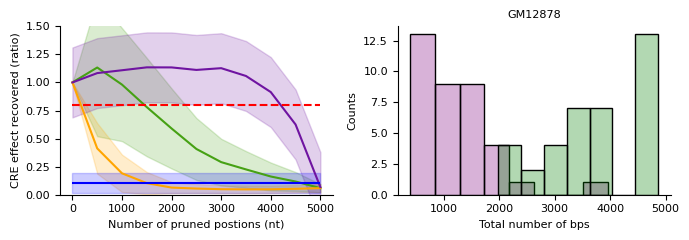

(63,)
Saliency
Random


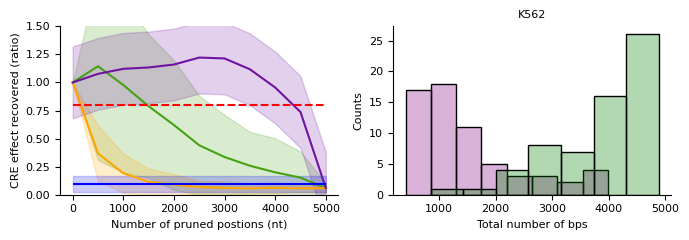

(29,)
Saliency
Random


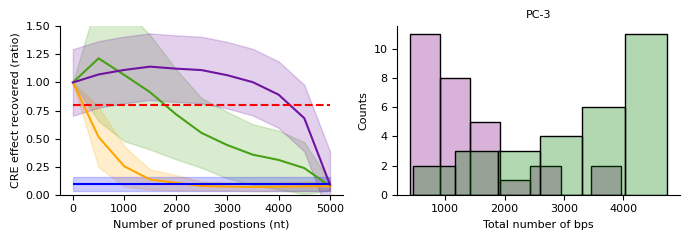

In [10]:
dfs = pd.read_csv(f"{csv_dir}/CREME_vs_saliency_vs_XSTREME.csv")
threshold_for_plotting = 0.8
c = ['#46a114', 'orange', '#a16f14']
for a, (cell_line, cell_df) in enumerate(dfs.groupby('cell_line')):
    print(cell_df['seq_id'].unique().shape)
    fig, axes = plt.subplots(1, 2, figsize=[7, 2.5])

    ax = axes[0]
    bps = np.arange(0, 5001, 500)
    mean_set = {'Saliency': [], 'Random': []}
    mean_set_CREME = []
    xstreme_scores = []
    bps_at_thresh = {'Saliency': [], 'CREME': []}
    for s, (seq_tile_id, one_seq_df) in enumerate(cell_df.groupby('seq_id')): 

        
        frac = one_seq_df['CREME score']
        mean_set_CREME.append(frac) # save to compute mean line
        

        mean_set['Saliency'].append(one_seq_df['Saliency score']) 
        mean_set['Random'].append(one_seq_df['Random score']) 
        #XSTREME results
        
        xstreme_scores.append(one_seq_df['XSTREME score'].values[0])
        bps_at_thresh['Saliency'].append(5000 - interp1d(one_seq_df['Saliency score'], bps)(threshold_for_plotting))
        bps_at_thresh['CREME'].append(5000-interp1d(frac, bps[:len(frac)])(threshold_for_plotting))
        
        
        
        
    longest_i = np.argmax([len(l) for l in mean_set_CREME])

    mean_set_CREME = np.array([np.pad(a, mode='constant',constant_values=(np.nan,),
                                      pad_width=(0, len(mean_set_CREME[longest_i])-len(a))) for a in mean_set_CREME])
    mean_set_CREME = np.nanmean(mean_set_CREME, axis=0)
    std_set_CREME = np.nanstd(mean_set_CREME, axis=0)

    for j, (k, v) in enumerate(mean_set.items()):
        print(k)
        mean = np.array(v).mean(axis=0)
        std = np.array(v).std(axis=0)
        ax.fill_between(bps, mean-std, mean+std, color=c[j], alpha=.2)
        ax.plot(bps, np.array(v).mean(axis=0), label=k, color=c[j])
        


    
    ax.plot(np.arange(0, 5500, 500), mean_set_CREME, label='CREME', color='#6f14a1')
    ax.fill_between(np.arange(0, 5500, 500), mean_set_CREME-std_set_CREME, mean_set_CREME+std_set_CREME, color='#6f14a1', alpha=.2)
    ax.hlines(threshold_for_plotting, 0, 5000, linestyle='--', color='r')
    # ax.hlines(thresholds[1], 0, 5000, linestyle='--', color='r', label='CREME threshold 50bp')
    xstreme_mean = np.mean(xstreme_scores)
    xstreme_std = np.std(xstreme_scores)

    ax.hlines(xstreme_mean, 0, 5000, color='blue', label='XSTREME')
    ax.fill_between(np.arange(0, 5500, 500), xstreme_mean-xstreme_std, xstreme_mean+xstreme_std, color='blue', alpha=.2)
    # if a==2:
    #     ax.legend(bbox_to_anchor=[1,1.5])
    # ax.set_title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fontsize=8
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    ax.set_xlabel('Number of pruned postions (nt)', fontsize=fontsize)
    ax.set_ylabel('CRE effect recovered (ratio)', fontsize=fontsize)
    
    
    # ax.set_xlim(0, 4500)
    ax.set_ylim(0, 1.5)
    
    sns.histplot(bps_at_thresh['CREME'], color='purple', ax=axes[1], alpha=0.3)
    sns.histplot(bps_at_thresh['Saliency'], color='green', ax=axes[1], alpha=0.3)

    plt.xlabel('Total number of bps', fontsize=fontsize)
    plt.ylabel('Counts', fontsize=fontsize)
    plt.title(cell_line, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    plt.tight_layout()
    fig.savefig(f"{pdf_dir}/average_traces_{cell_line}.pdf")
    plt.show()


# Salience in VS out of CREME motifs

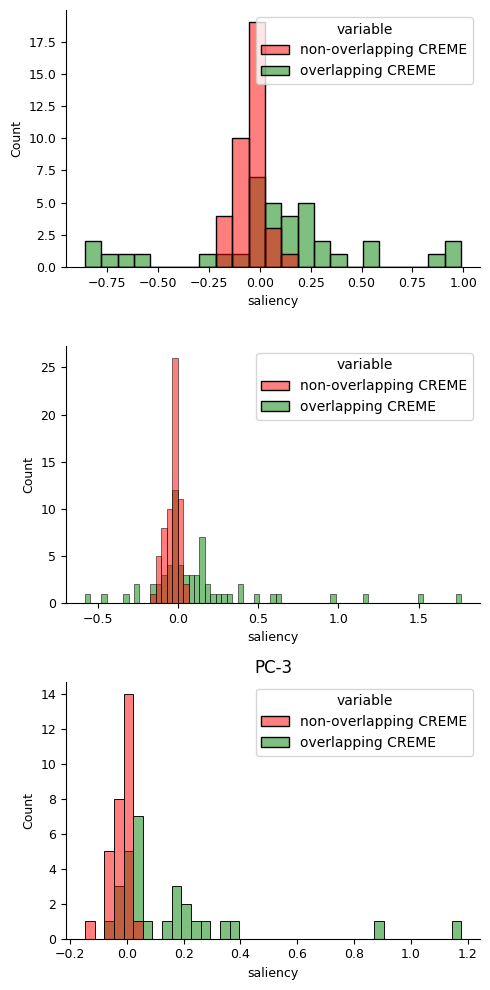

In [18]:
fontsize = 9
fig, axes = plt.subplots(3, 1, figsize=[5,10])

dfs = pd.read_csv(f'{csv_dir}/saliency_in_or_out_of_CREME_masks.csv', index_col='Unnamed: 0')
for p, (cell_line, df) in enumerate(dfs.groupby('cell_line')):
    ax = axes[p]
    sns.histplot(data=df.iloc[:,:2].melt(), x='value', hue='variable', palette=['r', 'g'], ax=ax)
    plt.title(cell_line)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_xlabel('saliency', fontsize=fontsize)

plt.tight_layout()
fig.savefig(f"{pdf_dir}/in_vs_out_saliency.pdf")
plt.show()


# EXAMPLE SALIENCY VS CREME VS XSTREME motifs

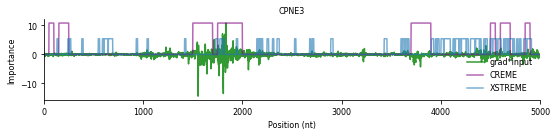

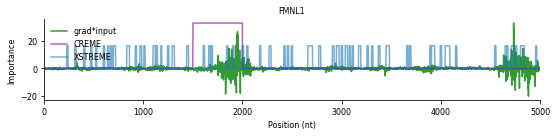

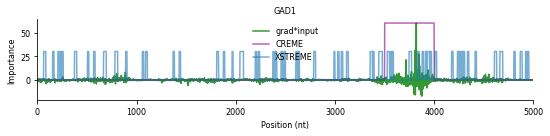

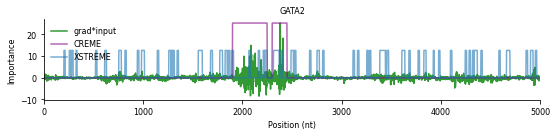

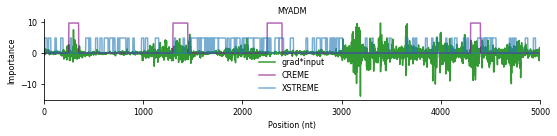

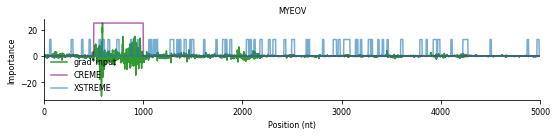

In [20]:
dfs = pd.read_csv(f'{csv_dir}/example_seqs.csv', index_col='Unnamed: 0')
for gene, df in dfs.groupby('gene'):
    
    fig, ax = plt.subplots(1, 1, figsize=[7.7, 2])
    ax.plot(df['Saliency'], alpha=0.8, label='grad*input', color='green')
    max_sal = np.max(df['Saliency'])
    
    ax.plot(df['CREME']*max_sal, label='CREME', color='purple', alpha=0.6)
    # plt.xlim(2000,2600)
    
    ax.plot([max_sal*0.5 if x else False for x in df['XSTREME']], label='XSTREME', alpha=0.6)
    
    ax.legend(fontsize=fontsize, frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fontsize=8
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    
    plt.xlabel('Position (nt)', fontsize=fontsize)
    plt.ylabel('Importance', fontsize=fontsize)
    ax.set_title(gene, fontsize=fontsize)
    plt.tight_layout()
    plt.xlim(0,5000)
    fig.savefig(f"{pdf_dir}/example_{gene}.pdf")
    plt.show()